In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nifty50-stock-market-data/HDFCBANK.csv
/kaggle/input/nifty50-stock-market-data/GRASIM.csv
/kaggle/input/nifty50-stock-market-data/WIPRO.csv
/kaggle/input/nifty50-stock-market-data/stock_metadata.csv
/kaggle/input/nifty50-stock-market-data/BPCL.csv
/kaggle/input/nifty50-stock-market-data/INFY.csv
/kaggle/input/nifty50-stock-market-data/LT.csv
/kaggle/input/nifty50-stock-market-data/RELIANCE.csv
/kaggle/input/nifty50-stock-market-data/BRITANNIA.csv
/kaggle/input/nifty50-stock-market-data/INFRATEL.csv
/kaggle/input/nifty50-stock-market-data/HEROMOTOCO.csv
/kaggle/input/nifty50-stock-market-data/HINDUNILVR.csv
/kaggle/input/nifty50-stock-market-data/TATAMOTORS.csv
/kaggle/input/nifty50-stock-market-data/MM.csv
/kaggle/input/nifty50-stock-market-data/HDFC.csv
/kaggle/input/nifty50-stock-market-data/JSWSTEEL.csv
/kaggle/input/nifty50-stock-market-data/TITAN.csv
/kaggle/input/nifty50-stock-market-data/HINDALCO.csv
/kaggle/input/nifty50-stock-market-data/AXISBANK.csv
/kaggle/inpu

In [2]:
!pip uninstall -y gym-anytrading stable-baselines3 gymnasium pandas matplotlib numpy tqdm


Found existing installation: gym-anytrading 2.0.0
Uninstalling gym-anytrading-2.0.0:
  Successfully uninstalled gym-anytrading-2.0.0
Found existing installation: stable_baselines3 2.7.0
Uninstalling stable_baselines3-2.7.0:
  Successfully uninstalled stable_baselines3-2.7.0
Found existing installation: gymnasium 1.2.2
Uninstalling gymnasium-1.2.2:
  Successfully uninstalled gymnasium-1.2.2
Found existing installation: pandas 2.3.3
Uninstalling pandas-2.3.3:
  Successfully uninstalled pandas-2.3.3
Found existing installation: matplotlib 3.10.7
Uninstalling matplotlib-3.10.7:
  Successfully uninstalled matplotlib-3.10.7
Found existing installation: numpy 2.3.5
Uninstalling numpy-2.3.5:
  Successfully uninstalled numpy-2.3.5
Found existing installation: tqdm 4.67.1
Uninstalling tqdm-4.67.1:
  Successfully uninstalled tqdm-4.67.1


In [3]:
!pip install gym-anytrading stable-baselines3 gymnasium pandas matplotlib numpy tqdm ta


  Using cached gym_anytrading-2.0.0-py3-none-any.whl.metadata (292 bytes)
  Using cached stable_baselines3-2.7.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached gymnasium-1.2.2-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.3-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached matplotlib-3.10.7-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached numpy-2.3.5-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached gym_anytrading-2.0.0-py3-none-any.whl (172 kB)
Using cached stable_baselines3-2.7.0-py3-none-any.whl (187 kB)
Using cached gymnasium-1.2.2-py3-none-any.whl (952 kB)
Using cached pandas-2.3.3-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (12.8 MB)
Using cached matplotlib-3.10.7-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached numpy-2.3.5-cp311-cp31

In [6]:
# =========================================
# FIX KAGGLE / STABLE-BASELINES IMPORT ERROR
# =========================================
import os

# Disable TensorBoard so TensorFlow is never imported
os.environ["DISABLE_TENSORBOARD"] = "1"

# Disable GPU in Kaggle container to avoid CUDA + TF conflicts
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Optional: reduce warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Now safe to import
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv


In [4]:
# ================================
# BLOCK 1 — DATA LOADING & FEATURES
# ================================
import pandas as pd
import numpy as np
import os

DATA_PATH = "/kaggle/input/nifty50-stock-market-data/"
TICKERS = ["LT", "TCS", "INFY", "HDFCBANK", "RELIANCE"]

# -------------------------------
# Indicator function
# -------------------------------
def compute_indicators(df, rsi_period=14, sma_period=10, ema_period=20):
    df = df.copy()

    # price must be float always
    df["Close"] = df["Close"].astype(float)

    # basic indicators
    df["returns"] = df["Close"].pct_change()

    df["sma_10"] = df["Close"].rolling(sma_period, min_periods=sma_period).mean()
    df["ema_20"] = df["Close"].ewm(span=ema_period, adjust=False).mean()

    # RSI
    delta = df["Close"].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.rolling(rsi_period, min_periods=rsi_period).mean()
    avg_loss = loss.rolling(rsi_period, min_periods=rsi_period).mean()

    rs = avg_gain / (avg_loss + 1e-9)
    df["rsi"] = 100 - (100 / (1 + rs))

    # Drop rows that are incomplete
    df = df.dropna().reset_index(drop=True)

    return df


# -------------------------------
# Load each stock individually
# -------------------------------
stock_data = {}

for ticker in TICKERS:
    file_path = os.path.join(DATA_PATH, f"{ticker}.csv")

    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)

    df = compute_indicators(df)

    # Scaling
    df["returns"] = df["returns"].clip(-0.2, 0.2)
    df["returns_scaled"] = df["returns"] * 20

    df["sma_10_scaled"] = df["sma_10"] / df["Close"]
    df["ema_20_scaled"] = df["ema_20"] / df["Close"]
    df["rsi_scaled"] = df["rsi"] / 100

    stock_data[ticker] = df

print("Loaded stocks:", list(stock_data.keys()))


Loaded stocks: ['LT', 'TCS', 'INFY', 'HDFCBANK', 'RELIANCE']


In [7]:
# ================================
# BLOCK 2 — ENVIRONMENT + TRAINING
# ================================
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

WINDOW = 30

# -------------------------
# Build feature windows
# -------------------------
def build_feature_matrix(features, window):
    pad = np.repeat(features[[0]], window, axis=0)
    stacked = np.vstack([pad, features])
    out = [stacked[i-window:i] for i in range(window, len(stacked))]
    return np.array(out, dtype=np.float32)

# -------------------------
# Prepare LT train/test
# -------------------------
df_lt = stock_data["LT"]

split_idx = int(len(df_lt) * 0.8)
train_df = df_lt.iloc[:split_idx].reset_index(drop=True)
test_df  = df_lt.iloc[split_idx:].reset_index(drop=True)

train_prices = train_df["Close"].values
train_feats  = train_df[["returns_scaled", "sma_10_scaled", "ema_20_scaled", "rsi_scaled"]].values
train_windows = build_feature_matrix(train_feats, WINDOW)

test_prices = test_df["Close"].values
test_feats  = test_df[["returns_scaled", "sma_10_scaled", "ema_20_scaled", "rsi_scaled"]].values
test_windows = build_feature_matrix(test_feats, WINDOW)

# -------------------------
# Trading Environment
# -------------------------
class FeatureTradingEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(
        self, prices, features_window, window_size=30,
        initial_cash=10000.0, transaction_cost=0.001,
        buy_fraction=0.5, sell_fraction=1.0
    ):
        super().__init__()
        self.prices = prices
        self.features_window = features_window
        self.window_size = window_size
        self.initial_cash = initial_cash
        self.transaction_cost = transaction_cost
        self.buy_fraction = buy_fraction
        self.sell_fraction = sell_fraction

        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(
            low=-10, high=10, shape=(window_size, 7), dtype=np.float32
        )

        self.reset()

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.cash = float(self.initial_cash)
        self.position = 0.0
        self.equity = float(self.initial_cash)
        self.idx = self.window_size
        return self._obs(), {}

    def step(self, action):
        price = float(self.prices[self.idx])
        prev_equity = self.equity

        # BUY
        if action == 2 and self.cash > 1e-6:
            spend = self.cash * self.buy_fraction
            units = (spend / price) * (1 - self.transaction_cost)
            self.position += units
            self.cash -= spend

        # SELL
        elif action == 0 and self.position > 1e-6:
            units = self.position * self.sell_fraction
            self.cash += units * price * (1 - self.transaction_cost)
            self.position -= units

        # Update equity
        self.equity = self.cash + self.position * price

        reward = (self.equity - prev_equity) / max(prev_equity, 1e-6)
        reward = float(np.clip(reward, -1, 1))

        self.idx += 1
        done = self.idx >= len(self.prices) - 1
        return self._obs(), reward, done, False, {
            "price": price,
            "equity": self.equity,
            "position": self.position,
            "cash": self.cash,
            "action": action,
        }

    def _obs(self):
        feat = self.features_window[self.idx]
        cash_norm = self.cash / self.initial_cash
        pos_norm = self.position
        eq_norm = self.equity / self.initial_cash
        extra = np.tile([cash_norm, pos_norm, eq_norm], (self.window_size, 1))
        return np.concatenate([feat, extra], axis=1).astype(np.float32)

# -------------------------
# Train PPO agent
# -------------------------
env = DummyVecEnv([lambda: FeatureTradingEnv(train_prices, train_windows, WINDOW)])
model = PPO("MlpPolicy", env, learning_rate=3e-4, batch_size=256, n_steps=2048, verbose=1)

model.learn(total_timesteps=200_000)
model.save("ppo_LT_trader")
print("Training complete.")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 980  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 832         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013731103 |
|    clip_fraction        | 0.0934      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -19.3       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00404     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 0.0752      |
-----------------------------------------
-----------------

In [10]:
# ================================
# BLOCK 3 — EVALUATION
# ================================
test_env = FeatureTradingEnv(test_prices, test_windows, WINDOW)

obs, _ = test_env.reset()
actions = []
prices  = []
equity_curve = []
buys = []
sells = []

done = False
t = 0

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = test_env.step(action)

    actions.append(action)
    prices.append(info["price"])
    equity_curve.append(info["equity"])

    if action == 2:
        buys.append((t, info["price"]))
    elif action == 0:
        sells.append((t, info["price"]))

    t += 1

final_equity = equity_curve[-1]
test_return = (final_equity - 10000) / 10000 * 100

print("Final Equity:", final_equity)
print("Test Return %:", test_return)
print("Buys:", len(buys), "Sells:", len(sells))


Final Equity: 18308.954673913435
Test Return %: 83.08954673913435
Buys: 215 Sells: 9


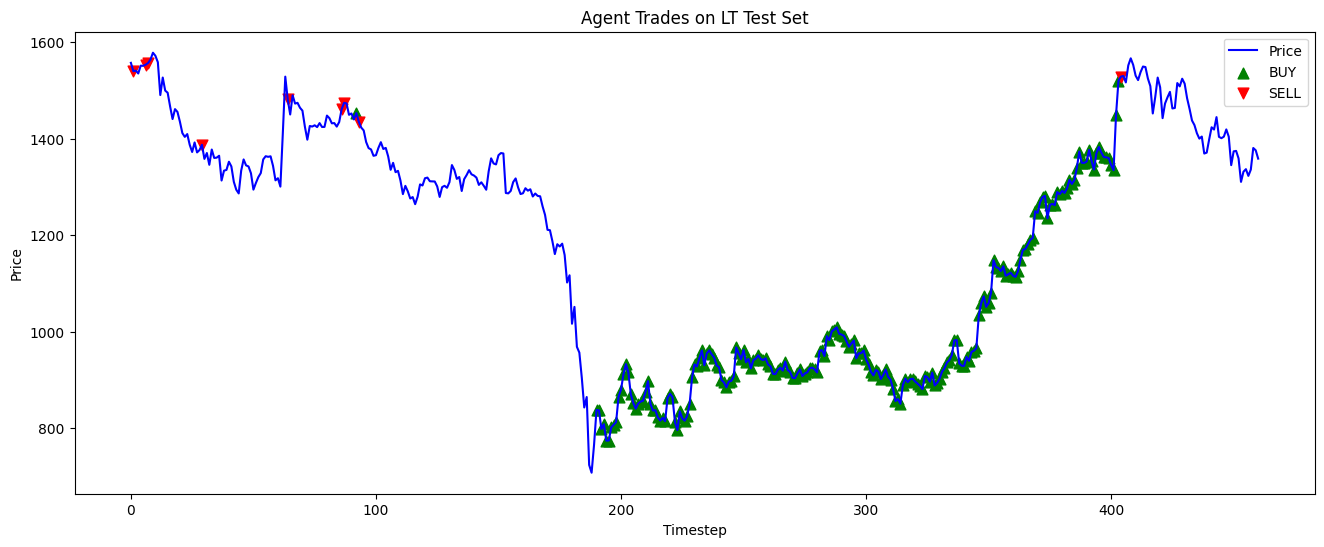

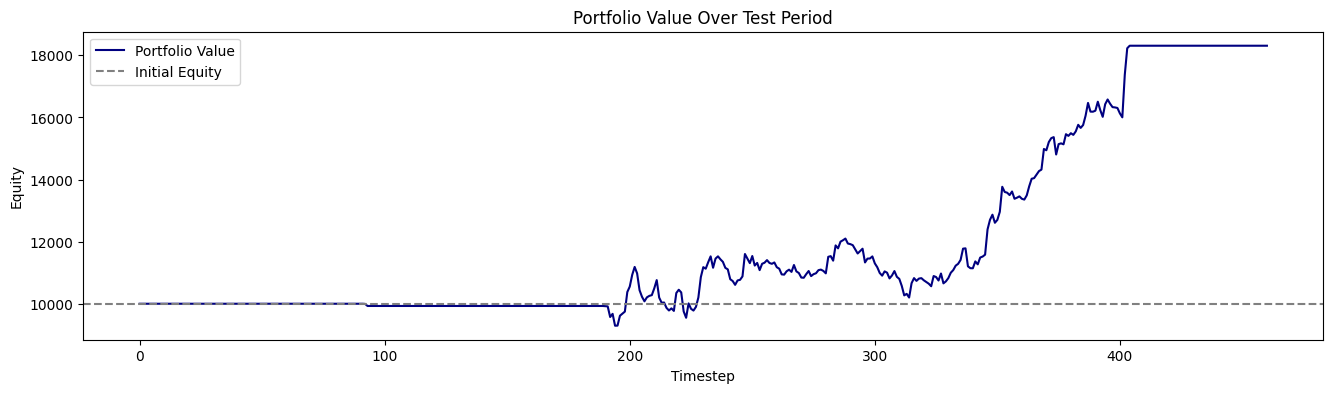

In [11]:
# ================================
# BLOCK 4 — PLOTTING
# ================================
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot(prices, label="Price", color="blue")

for t, p in buys:
    plt.scatter(t, p, color="green", marker="^", s=60, label="BUY" if t==buys[0][0] else "")

for t, p in sells:
    plt.scatter(t, p, color="red", marker="v", s=60, label="SELL" if t==sells[0][0] else "")

plt.title("Agent Trades on LT Test Set")
plt.xlabel("Timestep")
plt.ylabel("Price")
plt.legend()
plt.show()

# Portfolio value curve
plt.figure(figsize=(16,4))
plt.plot(equity_curve, label="Portfolio Value", color="navy")
plt.axhline(10000, color="gray", linestyle="--", label="Initial Equity")
plt.title("Portfolio Value Over Test Period")
plt.xlabel("Timestep")
plt.ylabel("Equity")
plt.legend()
plt.show()


In [12]:
def evaluate_on_stock(df, ticker_name):
    print(f"\n====== Evaluating on {ticker_name} ======\n")

    prices = df["Close"].values.astype(float)
    feats = df[["returns_scaled", "sma_10_scaled", "ema_20_scaled", "rsi_scaled"]].values.astype(np.float32)
    windows = build_feature_matrix(feats, WINDOW)

    env = FeatureTradingEnv(
        prices=prices,
        features_window=windows,
        window_size=WINDOW,
        initial_cash=10_000,
        transaction_cost=0.001,
        buy_fraction=0.5,
        sell_fraction=1.0,
        max_leverage=1.0,
    )

    obs, info = env.reset()
    portfolio_vals = []
    buys, sells = [], []

    for t in range(len(prices) - WINDOW - 1):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, trunc, info = env.step(action)

        # <-- IMPORTANT FIX: safe fallback
        pv = info.get("portfolio_value", env.portfolio_value)
        portfolio_vals.append(pv)

        # Track real trades
        if info["action"] == 2:  
            buys.append((t, prices[t]))
        elif info["action"] == 0 and env.position < 1e-6:  
            pass  # useless sell → ignore
        elif info["action"] == 0:
            sells.append((t, prices[t]))

        if done:
            break

    # Print summary
    print("True buys:", len(buys))
    print("True sells:", len(sells))
    if portfolio_vals:
        ret = (portfolio_vals[-1] / portfolio_vals[0] - 1) * 100
        print("Test Return %:", ret)
    else:
        print("Test Return %: NA")

    return buys, sells, portfolio_vals


In [13]:
evaluate_on_stock(feature_df[feature_df["Ticker"]=="INFY"].reset_index(drop=True), "INFY")
evaluate_on_stock(feature_df[feature_df["Ticker"]=="TCS"].reset_index(drop=True), "TCS")
evaluate_on_stock(feature_df[feature_df["Ticker"]=="HDFCBANK"].reset_index(drop=True), "HDFCBANK")


NameError: name 'feature_df' is not defined

In [ ]:
import numpy as np
import gymnasium as gym

class MultiStockTradingEnv(gym.Env):
    """
    Multi-stock env:
    - Each reset picks ONE stock episode from train_episodes.
    - Within an episode, time is strictly chronological.
    - Action: 0 = SELL, 1 = HOLD, 2 = BUY.
    """
    metadata = {"render_modes": []}

    def __init__(
        self,
        episodes,
        window_size=30,
        initial_cash=10_000.0,
        transaction_cost=0.001,
        buy_fraction=0.5,
        sell_fraction=1.0,
        max_leverage=1.0,
    ):
        super().__init__()
        assert len(episodes) > 0, "Need at least one episode."

        self.episodes = episodes
        self.window_size = window_size
        self.initial_cash = float(initial_cash)
        self.transaction_cost = float(transaction_cost)
        self.buy_fraction = float(buy_fraction)
        self.sell_fraction = float(sell_fraction)
        self.max_leverage = float(max_leverage)

        # assume all episodes share same feature dimension
        sample_fw = episodes[0]["features_window"]
        self.n_indicators = sample_fw.shape[2]
        self.n_obs_features = self.n_indicators + 3  # + cash, position, equity

        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(
            low=-10,
            high=10,
            shape=(self.window_size, self.n_obs_features),
            dtype=np.float32,
        )

        # placeholders (set in reset)
        self.current_prices = None
        self.current_feats = None
        self.current_ticker = None
        self.episode_len = None
        self.current_idx = None

        self.cash = None
        self.position = None
        self.portfolio_value = None
        self.max_position_units = None

    # ------------- helper to load one stock episode -------------
    def _set_episode(self, idx: int):
        ep = self.episodes[idx]
        self.current_prices = ep["prices"]
        self.current_feats = ep["features_window"]
        self.current_ticker = ep["ticker"]
        self.episode_len = len(self.current_prices)

        # leverage cap based on that stock's max price
        self.max_position_units = (
            self.initial_cash * self.max_leverage / max(1e-6, np.max(self.current_prices))
        )

    # ---------------------------- RESET -------------------------
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)

        # pick a random episode
        ep_idx = self.np_random.integers(len(self.episodes))
        self._set_episode(int(ep_idx))

        # fresh portfolio
        self.cash = float(self.initial_cash)
        self.position = 0.0
        self.portfolio_value = float(self.initial_cash)

        # start at first timestep
        self.current_idx = 0

        obs = self._get_obs()
        info = {
            "price": float(self.current_prices[self.current_idx]),
            "cash": self.cash,
            "position": self.position,
            "portfolio_value": self.portfolio_value,
            "ticker": self.current_ticker,
        }
        return obs, info

    # ----------------------------- STEP -------------------------
    def step(self, action):
        price = float(self.current_prices[self.current_idx])
        prev_equity = self.portfolio_value

        # ----- execute action -----
        # BUY
        if action == 2 and self.cash > 1e-6:
            spend = self.cash * self.buy_fraction
            units = (spend / price) * (1.0 - self.transaction_cost)
            self.position += units
            self.cash -= spend

        # SELL
        elif action == 0 and self.position > 1e-6:
            units_to_sell = self.position * self.sell_fraction
            proceeds = units_to_sell * price * (1.0 - self.transaction_cost)
            self.position -= units_to_sell
            self.cash += proceeds

        # enforce leverage cap
        if self.position > self.max_position_units:
            excess = self.position - self.max_position_units
            refund = excess * price * (1.0 - self.transaction_cost)
            self.position = self.max_position_units
            self.cash += refund

        # ----- recompute portfolio -----
        self.portfolio_value = self.cash + self.position * price
        self.portfolio_value = max(self.portfolio_value, 1e-6)

        pnl = self.portfolio_value - prev_equity
        reward = pnl / max(prev_equity, 1e-6)
        reward = float(np.clip(reward, -1.0, 1.0))

        # penalties for pointless trades
        if action == 0 and self.position < 1e-6:
            reward -= 0.01  # tried to sell with no position
        if action == 2 and self.cash < 1e-6:
            reward -= 0.01  # tried to buy with no cash

        # small friction
        if action in (0, 2):
            reward -= 0.001

        # ----- advance time -----
        self.current_idx += 1
        terminated = self.current_idx >= self.episode_len - 1
        truncated = False

        obs = self._get_obs()
        info = {
            "price": price,
            "cash": self.cash,
            "position": self.position,
            "portfolio_value": self.portfolio_value,
            "pnl": pnl,
            "action": int(action),
            "ticker": self.current_ticker,
        }
        return obs, reward, terminated, truncated, info

    # --------------------------- OBS ----------------------------
    def _get_obs(self):
        idx = min(self.current_idx, self.episode_len - 1)
        feat_win = self.current_feats[idx]  # (window, n_indicators)

        cash_norm = np.clip(self.cash / (self.initial_cash + 1e-9), -10, 10)
        pos_norm = np.clip(self.position, -10, 10)
        eq_norm = np.clip(self.portfolio_value / (self.initial_cash + 1e-9), -10, 10)

        extra = np.tile(
            np.array([cash_norm, pos_norm, eq_norm], dtype=np.float32),
            (self.window_size, 1),
        )
        obs = np.concatenate([feat_win, extra], axis=1).astype(np.float32)
        return obs


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# factory function for DummyVecEnv
def make_train_env():
    return MultiStockTradingEnv(
        episodes=train_episodes,
        window_size=WINDOW,
        initial_cash=10_000.0,
        transaction_cost=0.001,
        buy_fraction=0.5,
        sell_fraction=1.0,
        max_leverage=1.0,
    )

vec_env = DummyVecEnv([make_train_env])

model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=256,
    gamma=0.99,
    ent_coef=0.01,
    verbose=1,
)

model.learn(total_timesteps=200_000)
model.save("ppo_multistock_trader_v1")
print("✅ Training complete")


In [ ]:
import matplotlib.pyplot as plt

# ---------- build a single-episode LT test env ----------
lt_test = test_sets["LT"]
lt_episode = [{
    "ticker": "LT",
    "prices": lt_test["prices"],
    "features_window": lt_test["features_window"],
}]

test_env = MultiStockTradingEnv(
    episodes=lt_episode,
    window_size=WINDOW,
    initial_cash=10_000.0,
    transaction_cost=0.001,
    buy_fraction=0.5,
    sell_fraction=1.0,
    max_leverage=1.0,
)

obs, info = test_env.reset()
prices = []
equity = []
actions = []
positions = []

done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = test_env.step(int(action))

    prices.append(info["price"])
    equity.append(info["portfolio_value"])
    actions.append(info["action"])
    positions.append(info["position"])

    done = terminated or truncated

prices = np.array(prices)
equity = np.array(equity)
actions = np.array(actions)
positions = np.array(positions)

initial_eq = 10_000.0
final_eq = equity[-1]
test_return = (final_eq - initial_eq) / initial_eq * 100

print(f"Final Equity (LT test): {final_eq:.2f}")
print(f"Test Return %        : {test_return:.2f}%")

# ---------- mark TRUE buys/sells based on position changes ----------
buys_x, buys_y, sells_x, sells_y = [], [], [], []
prev_pos = 0.0
for t in range(len(actions)):
    pos = positions[t]
    if pos > prev_pos + 1e-6:    # net buy
        buys_x.append(t)
        buys_y.append(prices[t])
    elif pos < prev_pos - 1e-6:  # net sell
        sells_x.append(t)
        sells_y.append(prices[t])
    prev_pos = pos

print("True buys:", len(buys_x))
print("True sells:", len(sells_x))

# ---------- plotting ----------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

ax1.plot(prices, label="Price", linewidth=1)
ax1.scatter(buys_x, buys_y, marker="^", color="green", label="BUY", s=40)
ax1.scatter(sells_x, sells_y, marker="v", color="red", label="SELL", s=40)
ax1.set_title("Agent TRUE Trades on LT Test Set")
ax1.set_ylabel("Price")
ax1.legend(loc="upper left")

ax2.plot(equity, label="Portfolio Value", linewidth=1.5)
ax2.axhline(initial_eq, linestyle="--", color="gray", label="Initial Equity")
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Portfolio Value")
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()
